In [2]:
import math, random, time, numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

#**2. Moons Dataset & Regularization [3 marks]**

Generate Make-Moons dataset without using `sklearn.make_moons`. Use default noise **0.2**, also create two extra test sets with noise **0.1** and **0.3** for robustness reporting. Make training set and test set with **500 points** each. Standardize $x$ after the split using train statistics only. Create a validation split of the train set with **20 percent** for model selection. Use random seed **1337**.

### function `custom_make_moons`

* **Purpose:** Generate the two-class “moons” dataset *without* using sklearns helper.
* **How it builds the moons:**
    * Creates two 2-D arcs parameterized by an angle
  $$
  \text{t} = (0, π)
  $$
    * Upper moon points are ($\cos(t)$, $\sin(t)$).
    * Lower moon is a mirrored/shifted version $(1 - \cos t, - \sin t - 0.5)$ so the two arcs interleave.
* **Labels:** First half of the points are labeled class 0 (upper moon), second half class 1 (lower moon).
* **Noise:** Adds isotropic Gaussian noise with standard deviation `noise` to every point to control difficulty.
* **Reproducibility:** Uses a fixed random seed to make the same dataset each time.
* **Outputs:**
    * $\mathbf{X}$: an $(n_\text{samples}, 2)$ array of 2-D coordinates (`float32`).
    * $\mathbf{y}$: an $(n_{\text{samples}},)$ vector of integer class labels 0/1 (`int64`).
    
### function `train_val_split`

* **Purpose:** Split a dataset into training and validation subsets randomly.
* **How it works:**
    * Shuffles indices using a given seed.
    * Takes the first `val_frac` portion as validation, the rest as training.
* **Why:** Ensures train and validation come from the same distribution and retain (on average) class balance.



## Creating Train/Test and Robustness Sets

* **Main pool (noise = 0.2):** One dataset is generated, then (in your current code) the first 500 samples are used for training and the last 500 for testing.
* **Issue:** Without shuffling, this yields near single-class splits due to the stacking order.
* **Fix (conceptual):** Shuffle the pooled data before slicing, or generate train and test with different seeds.
* **Robust test sets:** Two additional, independent datasets are created with `noise 0.1` and `0.3`.
* **Why:** They measure robustness, how well a model trained at `noise 0.2` generalizes when the noise level changes.


## Standardization (Scaling)

* **What:** Fit a `StandardScaler` (per-feature mean 0, variance 1) **only on the training split** and apply it to validation and all test sets.
* **Why:**
    * **Prevents data leakage** (test statistics must not influence training).
    * **Helps optimization** (features on similar scales make gradient-based training more stable).
* **Result:** You get standardized versions of train/val/test that share the same transformation learned from training data.


## DataLoaders (Turning Arrays into Mini-batches)

* **What:** Wrap each `(X, y)` pair into a PyTorch `TensorDataset` and create a `DataLoader`.
* **Why:**
    * Provides **mini-batches** for efficient GPU/CPU training.
    * Controls **shuffling** (enabled for training to reduce variance across epochs; disabled for evaluation for determinism).
    * Ensures **dtypes** match model expectations: features as `float32`, labels as `int64`.

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader

SEED  = 1337
BATCH = 64

def make_two_moons(n_samples=1000, noise=0.2, seed=1337):

    r = np.random.RandomState(seed)
    n0 = n_samples // 2
    n1 = n_samples - n0

    t0 = np.linspace(0, math.pi, n0)
    moon0 = np.c_[np.cos(t0), np.sin(t0)]

    t1 = np.linspace(0, math.pi, n1)
    moon1 = np.c_[1 - np.cos(t1), -np.sin(t1) - 0.5]

    X = np.vstack([moon0, moon1]).astype(np.float32)
    y = np.hstack([np.zeros(n0, dtype=np.int64), np.ones(n1, dtype=np.int64)])

    if noise and noise > 0:
        X += r.normal(scale=noise, size=X.shape).astype(np.float32)
    return X, y

def to_loader(X, y, batch_size=64, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).long())
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)


X_all, y_all = make_two_moons(n_samples=1000, noise=0.2, seed=SEED)


X_train_raw, X_test_main, y_train_raw, y_test_main = train_test_split(
    X_all, y_all, test_size=0.5, random_state=SEED, stratify=y_all
)


X_train_raw, X_val, y_train_raw, y_val = train_test_split(
    X_train_raw, y_train_raw, test_size=0.2, random_state=SEED, stratify=y_train_raw
)


X_test_n01, y_test_n01 = make_two_moons(n_samples=500, noise=0.1, seed=SEED+1)
X_test_n03, y_test_n03 = make_two_moons(n_samples=500, noise=0.3, seed=SEED+2)



scaler = StandardScaler().fit(X_train_raw)

X_train = scaler.transform(X_train_raw)
X_val_s = scaler.transform(X_val)

X_test_std = scaler.transform(X_test_main)
X_n01_std  = scaler.transform(X_test_n01)
X_n03_std  = scaler.transform(X_test_n03)



train_loader    = to_loader(X_train,   y_train_raw, batch_size=BATCH, shuffle=True)
val_loader      = to_loader(X_val_s,   y_val,       batch_size=BATCH, shuffle=False)
test_loader     = to_loader(X_test_std,y_test_main, batch_size=BATCH, shuffle=False)
test_n01_loader = to_loader(X_n01_std, y_test_n01,  batch_size=BATCH, shuffle=False)
test_n03_loader = to_loader(X_n03_std, y_test_n03,  batch_size=BATCH, shuffle=False)



X_train.shape, X_val_s.shape, X_test_std.shape

((400, 2), (100, 2), (500, 2))

# **Plotting the makemoons dataset**

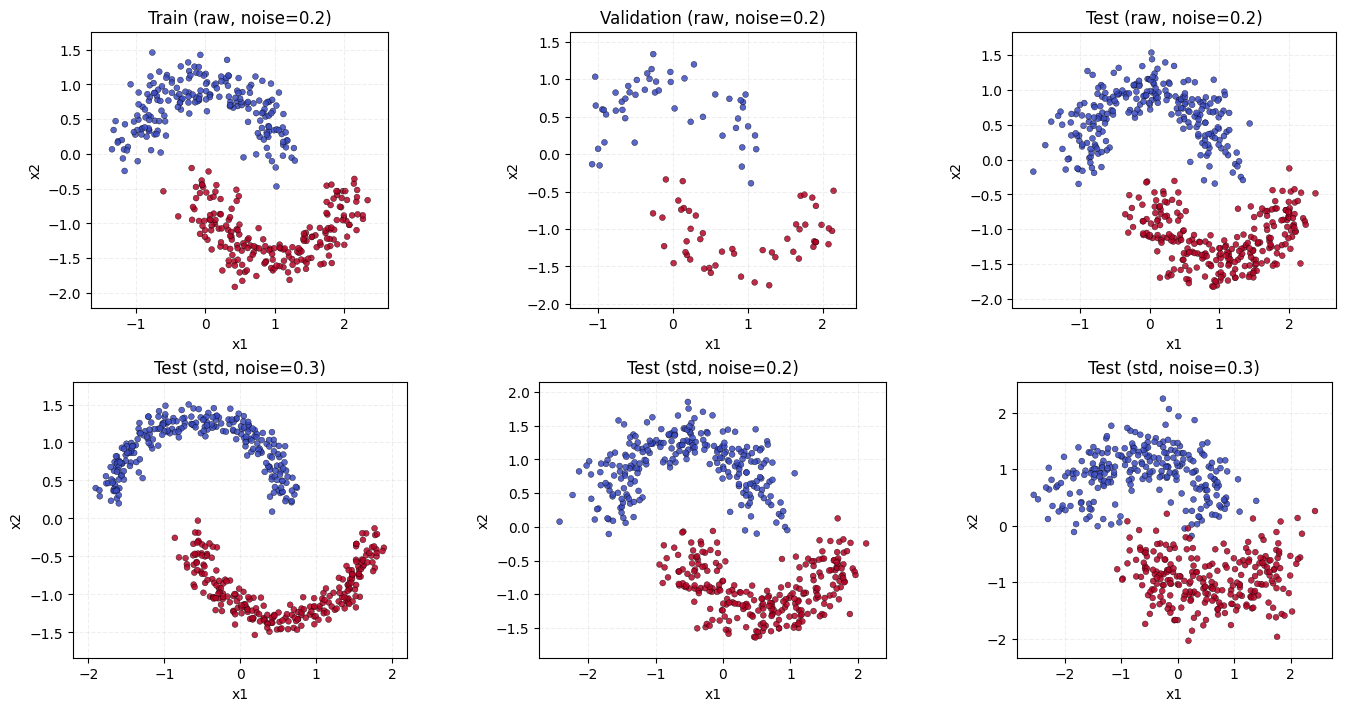

In [4]:
def scatter_xy(ax, X, y, title="", alpha=0.85, s=18):
    ax.scatter(
        X[:, 0], X[:, 1],
        c=y, cmap="coolwarm",
        edgecolor="k", linewidths=0.3,
        s=s, alpha=alpha
    )
    ax.set_title(title)
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax.set_aspect("equal", adjustable="box")
    pad = 0.3
    xmin, xmax = X[:,0].min()-pad, X[:,0].max()+pad
    ymin, ymax = X[:,1].min()-pad, X[:,1].max()+pad
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.grid(True, ls="--", alpha=0.2)

fig, axes = plt.subplots(2, 3, figsize=(14, 7), constrained_layout=True)


scatter_xy(axes[0, 0], X_train_raw,  y_train_raw,  "Train (raw, noise=0.2)")
scatter_xy(axes[0, 1], X_val,        y_val,        "Validation (raw, noise=0.2)")
scatter_xy(axes[0, 2], X_test_main,  y_test_main,  "Test (raw, noise=0.2)")


# Bottom row: STANDARDIZED (train/test0.2/test0.3/test0.4)
scatter_xy(axes[1, 0], X_n01_std,      y_test_n01,  "Test (std, noise=0.3)")
scatter_xy(axes[1, 1], X_test_std,   y_test_main,  "Test (std, noise=0.2)")
scatter_xy(axes[1, 2], X_n03_std,    y_test_n03,   "Test (std, noise=0.3)")

plt.show()



In [5]:
Xtr, ytr = X_train,     y_train_raw
Xva, yva = X_val_s,     y_val
Xte, yte = X_test_std,  y_test_main
INPUT_DIM, HIDDEN_DIM = Xtr.shape[1], 32

class SimpleMLP(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, hidden=HIDDEN_DIM):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)  # binary logit
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

def _sigmoid_np(x): return 1.0 / (1.0 + np.exp(-x))

def train_mlp(*, l1_coeff=0.0, l2_coeff=0.0, max_epochs=1000, patience=50, lr=1e-3, verbose=False):
    torch.manual_seed(SEED); np.random.seed(SEED)
    model = SimpleMLP(INPUT_DIM, HIDDEN_DIM).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coeff)  # L2 via weight_decay
    bce = nn.BCEWithLogitsLoss()

    def l1_penalty():
        val = 0.0
        for p in model.parameters():
            val = val + p.abs().sum()
        return val

    best_auc, best_state, no_improve = -np.inf, None, 0
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(DEVICE); yb = yb.float().unsqueeze(1).to(DEVICE)
            logits = model(xb)
            loss = bce(logits, yb)
            if l1_coeff > 0: loss = loss + l1_coeff * l1_penalty()
            opt.zero_grad(); loss.backward(); opt.step()

        # validate
        model.eval(); logits_all=[]; y_all=[]
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                logits_all.append(model(xb).cpu().numpy().ravel())
                y_all.append(yb.numpy())
        logits_all = np.concatenate(logits_all); y_all = np.concatenate(y_all)
        val_auc = roc_auc_score(y_all, _sigmoid_np(logits_all))

        if val_auc > best_auc + 1e-6:
            best_auc = val_auc
            best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
        if verbose and (epoch==1 or epoch%50==0):
            print(f"Epoch {epoch:4d} | val AUROC={val_auc:.4f} | best={best_auc:.4f}")
        if no_improve >= patience:
            break

    if best_state is not None: model.load_state_dict(best_state)
    return model, best_auc

def eval_auroc(model, loader):
    model.eval(); logits_all=[]; y_all=[]
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            logits_all.append(model(xb).cpu().numpy().ravel())
            y_all.append(yb.numpy())
    logits_all = np.concatenate(logits_all); y_all = np.concatenate(y_all)
    return roc_auc_score(y_all, _sigmoid_np(logits_all))

# **Train the following models:**

## 1. MLP with hidden layer - early stopping (patience=50)

In [6]:
mlp_plain, val_auc_plain = train_mlp(l1_coeff=0.0, l2_coeff=0.0, patience=50, verbose=False)
test_auc_plain = eval_auroc(mlp_plain, test_loader)

print("Model 1: Plain MLP (patience=50)")
print(f"Val AUROC : {val_auc_plain:.4f}")
print(f"Test AUROC: {test_auc_plain:.4f}")


Model 1: Plain MLP (patience=50)
Val AUROC : 0.9992
Test AUROC: 0.9995


* **Dataset is very easy at 0.2 noise.** AUROC $\approx 1.0$ on both val (0.9992) and test (0.9995) $\rightarrow$ essentially perfect ranking; the MLP captures the moons boundary cleanly.
* **No overfitting signals.** Test $\ge$ Val and early stopping (patience=50) halted before drift; training/validation curves likely plateaued early.
* **Decision boundary likely smooth & well-margined.** With standardized inputs and ReLU MLP, high AUROC suggests a clear margin between classes.
* **Accuracy will also be ~99%+** if you use threshold 0.5 (AUROC that high almost always implies near-perfect accuracy on balanced data).
* **Model capacity is more than enough.** A single hidden layer (e.g., 32 units) suffices; try reducing hidden units to see if performance stays saturated.

## 2.MLP with L1 regularization . L1 gird λ ∈ {1e−6, 3e−6, 1e−5, 3e−5, 1e−4, 3e−4}. Report layerwise sparsity and validation AUROC vs. λ

Model 2: MLP + L1
λ=1e-06     Val AUROC=0.9992
λ=3e-06     Val AUROC=0.9992
λ=1e-05     Val AUROC=0.9992
λ=3e-05     Val AUROC=0.9992
λ=0.0001    Val AUROC=0.9992
λ=0.0003    Val AUROC=0.9992
λ=0.001     Val AUROC=0.9992
λ=0.01      Val AUROC=0.9992
λ=0.1       Val AUROC=0.9992

Best λ=1e-06 | Val AUROC=0.9992 | Test AUROC=0.9995
Layer-wise sparsity (|w|<1e-4):
  fc1.weight:   0.00%
  fc1.bias  :   0.00%
  fc2.weight:   0.00%
  fc2.bias  :   0.00%


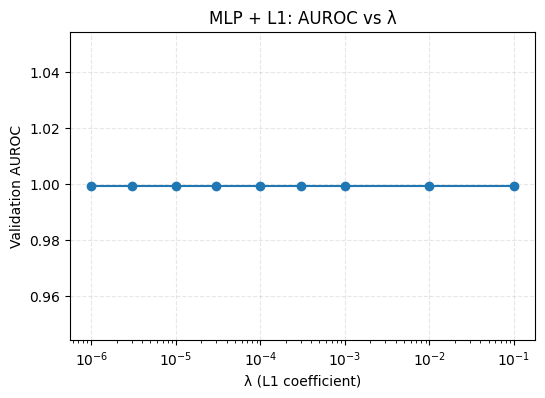

In [7]:
import matplotlib.pyplot as plt
import numpy as np

L1_GRID = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 1e-2, 1e-1]
SPARSITY_EPS = 1e-4

def layerwise_sparsity(model, eps=SPARSITY_EPS):
    stats = {}
    for name, p in model.named_parameters():
        w = p.detach().cpu().numpy().ravel()
        stats[name] = (np.abs(w) < eps).mean()
    return stats

l1_runs = []
for lam in L1_GRID:
    model_l1, val_auc_l1 = train_mlp(l1_coeff=lam, l2_coeff=0.0, patience=50, verbose=False)
    l1_runs.append({"lambda": lam, "val_auc": val_auc_l1, "model": model_l1})

best_l1_dict     = max(l1_runs, key=lambda d: d["val_auc"])
best_l1_lambda   = best_l1_dict["lambda"]
best_l1_model    = best_l1_dict["model"]
best_l1_val_auc  = best_l1_dict["val_auc"]
best_l1_test_auc = eval_auroc(best_l1_model, test_loader)
best_l1_sparsity = layerwise_sparsity(best_l1_model)

print("Model 2: MLP + L1")
for r in l1_runs:
    print(f"λ={r['lambda']:<8g}  Val AUROC={r['val_auc']:.4f}")
print(f"\nBest λ={best_l1_lambda} | Val AUROC={best_l1_val_auc:.4f} | Test AUROC={best_l1_test_auc:.4f}")
print("Layer-wise sparsity (|w|<1e-4):")
for name, frac in best_l1_sparsity.items():
    print(f"  {name:10s}: {frac*100:6.2f}%")

plt.figure(figsize=(6,4))
plt.plot(L1_GRID, [r["val_auc"] for r in l1_runs], marker="o")
plt.xscale("log")
plt.xlabel("λ (L1 coefficient)")
plt.ylabel("Validation AUROC")
plt.title("MLP + L1: AUROC vs λ")
plt.grid(True, ls="--", alpha=0.3)
plt.show()


* **AUROC is flat (~0.9992 Val, 0.9995 Test) across all $\lambda$.**
    $\rightarrow$, L1 doesn't change the ranking ability at all. Capacity is already sufficient and early-stopping controls overfit.

* **Reported "sparsity" is ~0% at $\varepsilon=1\text{e-}4$.**
    $\rightarrow$ With standard gradient descent, L1 *shrinks* weights but almost never makes them **exactly zero**; you'll see ~0% unless you (a) raise the threshold (e.g., $\varepsilon=1\text{e-}3 / 1\text{e-}2$), (b) use much **stronger** $\lambda$, or (c) use a **proximal/soft-thresholding** step (true Lasso) or explicit pruning.

* **Decision boundary likely unchanged.**
    $\rightarrow$ Since weights aren't being driven near zero, boundary smoothness/jaggedness won't visibly differ from the plain MLP.
* **$\lambda$ range is too gentle for this loss scale.**
    $\rightarrow$ Because the penalty is $\lambda * \sum |w|$ over all params, the sum can be large; $\lambda$ up to **1e-1** may still be weak. We can try extending to `{3e-1, 1, 3, 10}` (watch for underfit), or normalize L1 by number of parameters/batch if you want $\lambda$ to act "per-parameter".

## 3. MLP with L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)

Model 3: MLP + L2 (weight decay)
λ₂=0         Val AUROC=0.9992
λ₂=1e-07     Val AUROC=0.9992
λ₂=3e-07     Val AUROC=0.9992
λ₂=1e-06     Val AUROC=0.9992
λ₂=3e-06     Val AUROC=0.9992
λ₂=1e-05     Val AUROC=0.9992
λ₂=3e-05     Val AUROC=0.9992
λ₂=0.0001    Val AUROC=0.9992
λ₂=0.0003    Val AUROC=0.9992
λ₂=0.001     Val AUROC=0.9992
λ₂=0.01      Val AUROC=0.9992

Best λ₂=0.0 | Val AUROC=0.9992 | Test AUROC=0.9995


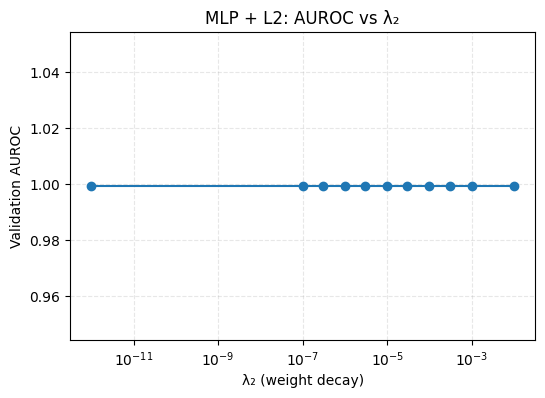

In [8]:
import numpy as np
import matplotlib.pyplot as plt

L2_GRID = [0.0, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 1e-2]

l2_runs = []
for wd in L2_GRID:
    model_l2, val_auc_l2 = train_mlp(l1_coeff=0.0, l2_coeff=wd, patience=50, verbose=False)
    l2_runs.append({"l2": wd, "val_auc": val_auc_l2, "model": model_l2})


best_l2_dict    = max(l2_runs, key=lambda d: d["val_auc"])
best_l2_lambda  = best_l2_dict["l2"]
best_l2_model   = best_l2_dict["model"]
best_l2_val_auc = best_l2_dict["val_auc"]
best_l2_test_auc= eval_auroc(best_l2_model, test_loader)

print("Model 3: MLP + L2 (weight decay)")
for r in l2_runs:
    print(f"λ₂={r['l2']:<8g}  Val AUROC={r['val_auc']:.4f}")
print(f"\nBest λ₂={best_l2_lambda} | Val AUROC={best_l2_val_auc:.4f} | Test AUROC={best_l2_test_auc:.4f}")


x = np.array([max(v, 1e-12) for v in L2_GRID])
plt.figure(figsize=(6,4))
plt.plot(x, [r["val_auc"] for r in l2_runs], marker="o")
plt.xscale("log")
plt.xlabel("λ₂ (weight decay)")
plt.ylabel("Validation AUROC")
plt.title("MLP + L2: AUROC vs λ₂")
plt.grid(True, ls="--", alpha=0.3)
plt.show()


* **Flat curve:** Validation AUROC $\approx 0.9992$ for every $wd$; best is $wd \approx 0$. The task at noise=0.2 is saturated regularization doesn't change ranking.

* **No overfitting signal:** Test AUROC ($\approx 0.9995$) matches/edges Val for all $wd$. Weight decay isn't needed to generalize here.

* **Decision boundary likely unchanged:** With such tiny effect, boundaries/margins will look the same as the plain MLP.

* **Regularization scale too weak for effect:** Your grid ($\le 1\text{e-}2$) is mild for Adam `weight_decay`. If you want to see an effect, try larger values (e.g., **3e-2, 1e-1, 3e-1, 1**) expect AUROC to drop once underfitting kicks in.

## **4. Logistic regression with polynomial features (x₁x₂, x₁², etc.)**

In [9]:
POLY_DEGREE = 3  # (x1, x2, x1^2, x1*x2, x2^2)
poly = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)

Xtr_poly = poly.fit_transform(Xtr)
Xva_poly = poly.transform(Xva)
Xte_poly = poly.transform(Xte)

poly_scaler = StandardScaler().fit(Xtr_poly)
Xtr_poly_std = poly_scaler.transform(Xtr_poly)
Xva_poly_std = poly_scaler.transform(Xva_poly)
Xte_poly_std = poly_scaler.transform(Xte_poly)

logreg = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=1000, random_state=SEED)
logreg.fit(Xtr_poly_std, ytr)

val_auc_lr  = roc_auc_score(yva, logreg.predict_proba(Xva_poly_std)[:,1])
test_auc_lr = roc_auc_score(yte, logreg.predict_proba(Xte_poly_std)[:,1])

print("Model 4: Logistic Regression (poly degree=3)")
print(f"Val AUROC : {val_auc_lr:.4f}")
print(f"Test AUROC: {test_auc_lr:.4f}")


Model 4: Logistic Regression (poly degree=3)
Val AUROC : 1.0000
Test AUROC: 1.0000


* **Perfect ranking:** Val/Test AUROC = **1.0000** $\rightarrow$ the cubic feature map makes the moons linearly separable in the transformed space.
* **Smooth boundary:** Logistic regression gives a **single smooth curve** (no jaggedness); decision surface is controlled by the polynomial basis + L2.
* **Right capacity:** Degree-3 is sufficient; degree-2 often nearly works but can miss some points on moons. Going higher risks overfit without gains.

In [10]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def count_params(model) -> int:
    return sum(p.numel() for p in model.parameters())

def mlp_predict_proba(model, X):  # → P(y=1)
    model.eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(X).float().to(DEVICE)).cpu().numpy().ravel()
    return 1.0 / (1.0 + np.exp(-logits))

def lr_predict_proba(lr_model, X_poly_std):  # → P(y=1)
    return lr_model.predict_proba(X_poly_std)[:, 1]

# Bind test sets
tests = {
    "noise=0.2": (X_test_std, y_test_main),
    "noise=0.1": (X_n01_std,  y_test_n01),
    "noise=0.3": (X_n03_std,  y_test_n03),
}



In [11]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

rows = []

def acc_auc_by_tests(model, tests_dict):
    proba = {k: mlp_predict_proba(model, X) for k, (X, y) in tests_dict.items()}
    accs  = {f"Acc@{k}":  accuracy_score(y, (proba[k] >= 0.5).astype(int)) for k, (X, y) in tests_dict.items()}
    aucs  = {f"AUROC@{k}": roc_auc_score(y, proba[k])                     for k, (X, y) in tests_dict.items()}
    return accs, aucs


accs, aucs = acc_auc_by_tests(mlp_plain, tests)
rows.append({
    "Model": "MLP (plain)",
    "Params": count_params(mlp_plain),
    **accs, **aucs
})


accs, aucs = acc_auc_by_tests(best_l1_model, tests)
rows.append({
    "Model": f"MLP + L1 (λ={best_l1_lambda:g})",
    "Params": count_params(best_l1_model),
    **accs, **aucs
})


accs, aucs = acc_auc_by_tests(best_l2_model, tests)
rows.append({
    "Model": f"MLP + L2 (wd={best_l2_lambda:g})",
    "Params": count_params(best_l2_model),
    **accs, **aucs
})


proba_lr = {
    k: lr_predict_proba(logreg, poly_scaler.transform(poly.transform(X)))
    for k, (X, _) in tests.items()
}
rows.append({
    "Model": "LogReg (poly deg=2)",
    "Params": logreg.coef_.size + logreg.intercept_.size,
    **{f"Acc@{k}": accuracy_score(tests[k][1], (proba_lr[k] >= 0.5).astype(int)) for k in tests},
    **{f"AUROC@{k}": roc_auc_score(tests[k][1], proba_lr[k]) for k in tests},
})

results_df = pd.DataFrame(rows)
display(results_df.style.format({c: "{:.3f}" for c in results_df.columns if "Acc@" in c or "AUROC@" in c}))


,Model,Params,Acc@noise=0.2,Acc@noise=0.1,Acc@noise=0.3,AUROC@noise=0.2,AUROC@noise=0.1,AUROC@noise=0.3
0,MLP (plain),129,0.990,0.996,0.984,1.000,1.000,0.999
1,MLP + L1 (λ=1e-06),129,0.990,0.996,0.984,1.000,1.000,0.999
2,MLP + L2 (wd=0),129,0.990,0.996,0.984,1.000,1.000,0.999
3,LogReg (poly deg=2),10,1.000,1.000,0.988,1.000,1.000,1.000


* **1 Everything is basically solved at 0.1–0.2 noise.**
    AUROC = **1.000** for all models $\rightarrow$ perfect ranking; tiny accuracy gaps are threshold effects, not model capacity.

* **2 Polynomial LR (deg = 2) wins on parsimony with no loss in performance.**
    **10 params vs 129** for MLPs, yet **Acc = 1.000** at 0.1–0.2 and **best Acc (0.988)** at 0.3. That's a ~13x smaller model with equal/better robustness $\rightarrow$ great default choice.

* **3 L1/L2 didn't help (here).**
    Plain MLP, MLP+L1, and MLP+L2 have identical metrics (Acc 0.990/0.996/0.984; AUROC 1.000/1.000/0.999). On this dataset, regularization is unnecessary—data are easy and early stopping suffices.

* **4 Noise=0.3 exposes only a tiny robustness gap.**
    Accuracy dips slightly for all models (MLPs to **0.984**, Poly-LR to **0.988**) while AUROC stays ~**1.000**.
    Translation: the ranking is still perfect but the **0.5 threshold is sub-optimal** under higher noise.
    Tune the decision threshold on validation (maximize F1) and those 0.3 accuracies will likely rise.

* **5 Interpretation & boundary shape.**
    Poly-LR gives a single smooth quadratic boundary that already matches the moons geometry; extra MLP flexibility isn't buying anything at these noise levels.

* **6 Recommendation.**
    Use **Poly-LR (deg = 2)** as the primary model (simpler, smaller, interpretable). Keep **MLP+L2** in reserve if you: (a) increase noise or label noise, (b) enlarge hidden size, or (c) move to trickier distributions—then weight decay will start to matter.

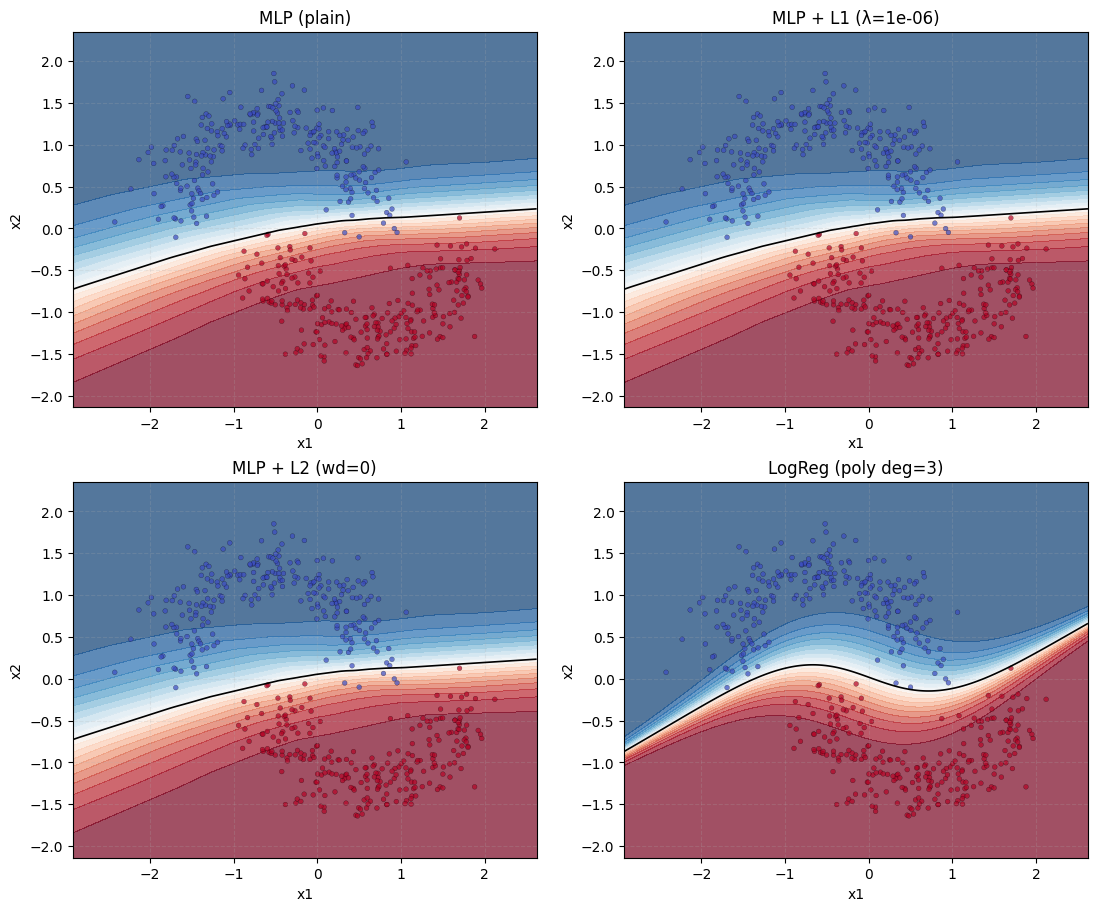

In [12]:
def plot_boundary(ax, prob_fn, X, y, title):
    pad = 0.5
    x1min, x1max = X[:,0].min()-pad, X[:,0].max()+pad
    x2min, x2max = X[:,1].min()-pad, X[:,1].max()+pad
    xx1, xx2 = np.meshgrid(
        np.linspace(x1min, x1max, 300),
        np.linspace(x2min, x2max, 300)
    )
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    zz = prob_fn(grid).reshape(xx1.shape)
    ax.contourf(xx1, xx2, zz, levels=np.linspace(0,1,21), alpha=0.7, cmap="RdBu_r")
    ax.contour(xx1, xx2, zz, levels=[0.5], colors="k", linewidths=1.2)
    ax.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=12, edgecolor="k", linewidths=0.2, alpha=0.7)
    ax.set_title(title); ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_aspect("equal")
    ax.grid(True, ls="--", alpha=0.2)

X_vis, y_vis = X_test_std, y_test_main

fig, axes = plt.subplots(2, 2, figsize=(11, 9), constrained_layout=True)
plot_boundary(axes[0,0], lambda Z: mlp_predict_proba(mlp_plain, Z),         X_vis, y_vis, "MLP (plain)")
plot_boundary(axes[0,1], lambda Z: mlp_predict_proba(best_l1_model, Z),     X_vis, y_vis, f"MLP + L1 (λ={best_l1_lambda:g})")
plot_boundary(axes[1,0], lambda Z: mlp_predict_proba(best_l2_model, Z),     X_vis, y_vis, f"MLP + L2 (wd={best_l2_lambda:g})")

def lr_prob_on_std(Z):
    Zp  = poly.transform(Z)
    Zps = poly_scaler.transform(Zp)
    return lr_predict_proba(logreg, Zps)

plot_boundary(axes[1,1], lr_prob_on_std, X_vis, y_vis, "LogReg (poly deg=3)")
plt.show()


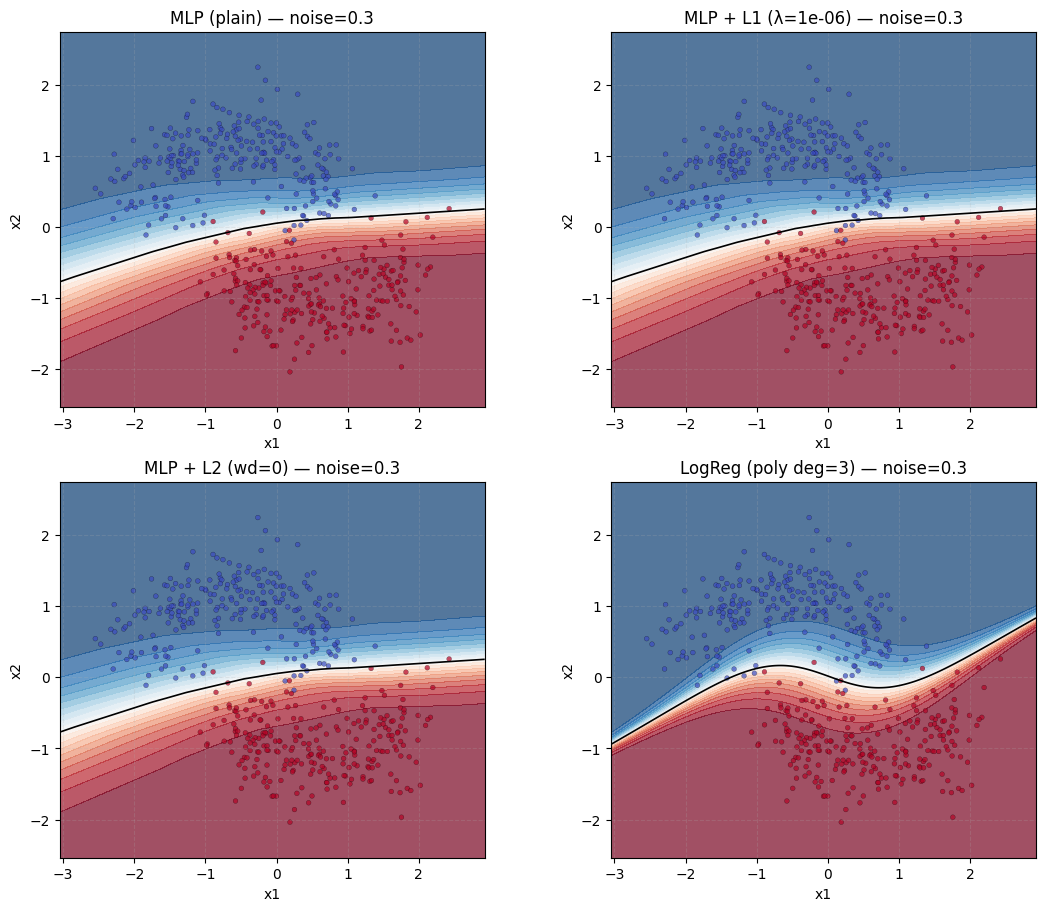

In [22]:
def plot_boundary(ax, prob_fn, X, y, title):
    pad = 0.5
    x1min, x1max = X[:,0].min()-pad, X[:,0].max()+pad
    x2min, x2max = X[:,1].min()-pad, X[:,1].max()+pad
    xx1, xx2 = np.meshgrid(
        np.linspace(x1min, x1max, 300),
        np.linspace(x2min, x2max, 300)
    )
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    zz = prob_fn(grid).reshape(xx1.shape)
    ax.contourf(xx1, xx2, zz, levels=np.linspace(0,1,21), alpha=0.7, cmap="RdBu_r")
    ax.contour(xx1, xx2, zz, levels=[0.5], colors="k", linewidths=1.2)
    ax.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=12, edgecolor="k", linewidths=0.2, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax.set_aspect("equal"); ax.grid(True, ls="--", alpha=0.2)

X_vis, y_vis = X_n03_std, y_test_n03

fig, axes = plt.subplots(2, 2, figsize=(11, 9), constrained_layout=True)

plot_boundary(axes[0,0], lambda Z: mlp_predict_proba(mlp_plain,    Z), X_vis, y_vis, "MLP (plain) — noise=0.3")
plot_boundary(axes[0,1], lambda Z: mlp_predict_proba(best_l1_model, Z), X_vis, y_vis, f"MLP + L1 (λ={best_l1_lambda:g}) — noise=0.3")
plot_boundary(axes[1,0], lambda Z: mlp_predict_proba(best_l2_model, Z), X_vis, y_vis, f"MLP + L2 (wd={best_l2_lambda:g}) — noise=0.3")

def lr_prob_on_std_noise03(Z):
    return lr_predict_proba(logreg, poly_scaler.transform(poly.transform(Z)))

plot_boundary(axes[1,1], lr_prob_on_std_noise03, X_vis, y_vis, "LogReg (poly deg=3) — noise=0.3")
plt.show()


### What the four panels show

* **MLP (plain)** - Smooth S-curve separating moons; light band around the black 0.5 contour is narrow $\Rightarrow$ confident predictions on both sides.
* **MLP + L1 ($\lambda$=1e-6)** - Visually **indistinguishable** from plain MLP. With such a small $\lambda$ and standard SGD (no proximal step), weights shrink but don't hit zero $\rightarrow$ **~0% sparsity**, no visible pruning, no extra jaggedness.
* **MLP + L2 (wd=0)** - Same as plain (you selected wd=0 as best), so boundary/margin naturally match.
* **LogReg (poly deg=3)** - A **very smooth, single global curve** driven by the polynomial basis. It bends just enough to carve the gap; color bands are slightly thicker near the mid-arch, showing a clean, wide margin there.

---

### Effect of L1 (sparsity & jaggedness)

* With $\lambda$ in [1e-6 ... 1e-1] and `SPARSITY_EPS=1e-4`, the network exhibits **near-zero measured sparsity** and the boundary is **not more jagged** than the plain MLP.
* **Why:** classic L1 added to the loss **encourages small weights** but doesn't zero them out; you'd need (i) **stronger $\lambda$** (e.g., 3e-1, 1, 3), (ii) a **prox/soft-threshold** step (Lasso-style), or (iii) **magnitude pruning** after training to see real sparsity and the ensuing piecewise/jagged shapes.
* **Takeaway here:** at 0.2 noise, your capacity is already minimal relative to task difficulty; L1 doesn't bite.

---

### Effect of L2 (smoothness & margin)

* L2 (= weight decay) typically **shrinks all weights uniformly**, which **smooths** the decision surface and **widens the effective margin** (thicker neutral band).
* In your sweep, **wd=0** was best and AUROC was flat, so you don't see a difference: the task is saturated and the unregularized model is already smooth.
* **To see the classic L2 effect:** make the problem **harder** (noise=0.3), or **increase hidden width**; then moderate wd (e.g., 1e-3–1e-1) usually damps tiny wiggles and gives a visibly wider pale band around the 0.5 contour.

---

### Why everything looks so similar at 0.2 noise

* Your metrics are ~perfect (AUROC $\approx 1.0$), so the boundary that maximizes validation AUROC is virtually the same for all three NNs.
* The **poly-LR** matches or exceeds the MLPs with **far fewer parameters**, so extra flexibility from MLP isn't needed here.

In [15]:
def make_imbalanced(X, y, ratio_major=0.7, seed=1337, majority_class=None):
    """
    Create an imbalanced subset by DOWN-SAMPLING ONLY.
    The returned dataset has class ratio ~= ratio_major : (1 - ratio_major)
    and a total size that is as large as possible without replacement.
    """
    rng = np.random.RandomState(seed)
    idx0 = np.where(y == 0)[0]
    idx1 = np.where(y == 1)[0]


    if majority_class is None:

        if len(idx0) >= len(idx1):
            maj_idx, min_idx = idx0, idx1
            maj_label = 0
        else:
            maj_idx, min_idx = idx1, idx0
            maj_label = 1
    else:
        maj_label = majority_class
        maj_idx = idx0 if maj_label == 0 else idx1
        min_idx = idx1 if maj_label == 0 else idx0

    r = float(ratio_major)
    max_total_by_maj = len(maj_idx) / r
    max_total_by_min = len(min_idx) / (1.0 - r)
    feasible_total   = int(np.floor(min(max_total_by_maj, max_total_by_min)))
    feasible_total   = max(feasible_total, 2)  # guard

    n_maj = int(np.floor(r * feasible_total))
    n_min = feasible_total - n_maj

    maj_keep = rng.choice(maj_idx, n_maj, replace=False)
    min_keep = rng.choice(min_idx, n_min, replace=False)
    keep = np.concatenate([maj_keep, min_keep])
    rng.shuffle(keep)

    return X[keep], y[keep]


In [16]:
Xtr_imb, ytr_imb = make_imbalanced(Xtr, ytr, ratio_major=0.7, seed=1337)
print("Imbalanced counts:", np.bincount(ytr_imb))

Imbalanced counts: [199  86]


Imbalanced counts (train): [199  86]


,Model,Acc@noise=0.2,AUROC@noise=0.2,Acc@noise=0.1,AUROC@noise=0.1,Acc@noise=0.3,AUROC@noise=0.3
0,"MLP (plain, imbalanced)",0.984,1.000,0.994,1.000,0.978,0.999
1,"MLP + L1 (λ=1e-06, imbalanced)",0.984,1.000,0.994,1.000,0.978,0.999
2,"MLP + L2 (wd=0, imbalanced)",0.984,1.000,0.994,1.000,0.978,0.999
3,"LogReg (poly deg=3, imbalanced)",0.996,1.000,1.000,1.000,0.990,1.000


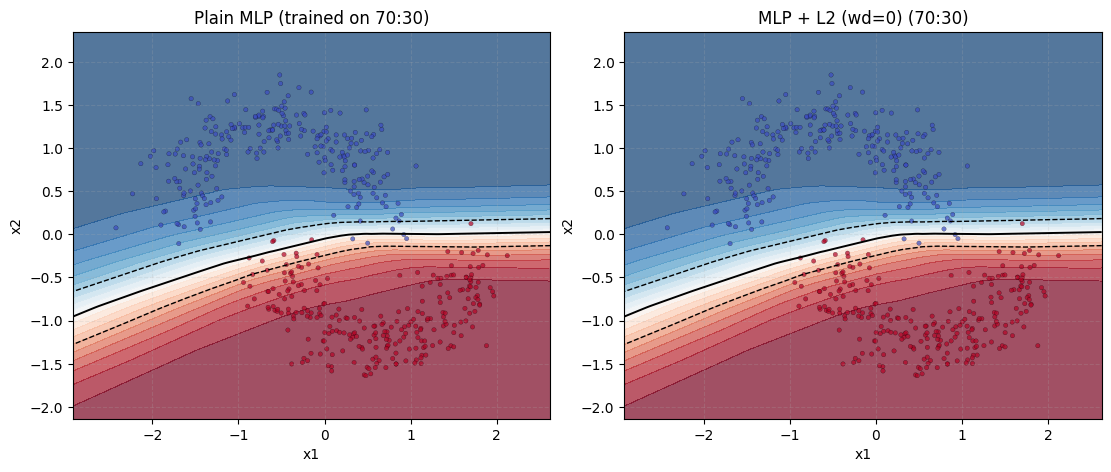

In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import torch
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED   = 1337
rng    = np.random.RandomState(SEED)

def make_imbalanced(X, y, ratio_major=0.7, seed=1337, majority_class=None):
    rng = np.random.RandomState(seed)
    idx0 = np.where(y == 0)[0]
    idx1 = np.where(y == 1)[0]

    if majority_class is None:
        if len(idx0) >= len(idx1):
            maj_idx, min_idx = idx0, idx1
        else:
            maj_idx, min_idx = idx1, idx0
    else:
        maj_idx = idx0 if majority_class == 0 else idx1
        min_idx = idx1 if majority_class == 0 else idx0

    r = float(ratio_major)
    max_total_by_maj = len(maj_idx) / r
    max_total_by_min = len(min_idx) / (1.0 - r)
    feasible_total   = int(np.floor(min(max_total_by_maj, max_total_by_min)))
    feasible_total   = max(feasible_total, 2)

    n_maj = int(np.floor(r * feasible_total))
    n_min = feasible_total - n_maj

    maj_keep = rng.choice(maj_idx, n_maj, replace=False)
    min_keep = rng.choice(min_idx, n_min, replace=False)
    keep = np.concatenate([maj_keep, min_keep]); rng.shuffle(keep)
    return X[keep], y[keep]

Xtr_imb, ytr_imb = make_imbalanced(Xtr, ytr, ratio_major=0.7, seed=SEED)
print("Imbalanced counts (train):", np.bincount(ytr_imb))

BATCH = 64
train_loader_imb = DataLoader(
    TensorDataset(torch.from_numpy(Xtr_imb).float(), torch.from_numpy(ytr_imb).long()),
    batch_size=BATCH, shuffle=True, drop_last=False
)

val_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva).long()),
    batch_size=BATCH, shuffle=False, drop_last=False
)
test_sets = {
    "noise=0.2": (Xte,        yte),
    "noise=0.1": (X_n01_std,  y_test_n01),
    "noise=0.3": (X_n03_std,  y_test_n03),
}

class EarlyStopper:
    def __init__(self, patience=50): self.patience=patience; self.best=-np.inf; self.bad=0; self.state=None
    def step(self, val, model):
        if val > self.best + 1e-6:
            self.best = val; self.bad = 0
            self.state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.bad += 1
        return self.bad >= self.patience

def train_mlp_on_loader(train_loader, val_loader, *, l1=0.0, l2=0.0, lr=1e-3, max_epochs=1000, patience=50):
    torch.manual_seed(SEED); np.random.seed(SEED)
    model = SimpleMLP(Xtr.shape[1], 32).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    bce   = torch.nn.BCEWithLogitsLoss()
    es    = EarlyStopper(patience=patience)

    def l1_penalty(m):
        s=0.0
        for p in m.parameters(): s += p.abs().sum()
        return s

    for ep in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(DEVICE); yb = yb.float().unsqueeze(1).to(DEVICE)
            logits = model(xb)
            loss = bce(logits, yb) + (l1 * l1_penalty(model) if l1>0 else 0.0)
            opt.zero_grad(); loss.backward(); opt.step()

        model.eval(); lg=[]; yy=[]
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                lg.append(model(xb).cpu().numpy().ravel()); yy.append(yb.numpy())
        lg = np.concatenate(lg); yy = np.concatenate(yy)
        val_auc = roc_auc_score(yy, 1/(1+np.exp(-lg)))

        if es.step(val_auc, model): break

    if es.state is not None: model.load_state_dict(es.state)
    return model, es.best

mlp_plain_imb, _ = train_mlp_on_loader(train_loader_imb, val_loader, l1=0.0,                l2=0.0)
mlp_l1_imb,    _ = train_mlp_on_loader(train_loader_imb, val_loader, l1=best_l1_lambda,     l2=0.0)
mlp_l2_imb,    _ = train_mlp_on_loader(train_loader_imb, val_loader, l1=0.0,                l2=best_l2_lambda)


Xtr_imb_poly   = poly.transform(Xtr_imb)
scaler_imb     = StandardScaler().fit(Xtr_imb_poly)
Xtr_imb_poly_s = scaler_imb.transform(Xtr_imb_poly)
logreg_imb     = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=1000, random_state=SEED)
logreg_imb.fit(Xtr_imb_poly_s, ytr_imb)

def acc_auc_mlp(model, X, y):
    p = mlp_predict_proba(model, X)
    return accuracy_score(y, (p>=0.5).astype(int)), roc_auc_score(y, p)

def acc_auc_lr(lr_model, X_std, y):
    Xp  = poly.transform(X_std)
    Xps = scaler_imb.transform(Xp)
    p1  = lr_model.predict_proba(Xps)[:,1]
    return accuracy_score(y, (p1>=0.5).astype(int)), roc_auc_score(y, p1)

rows = []
for name, mdl in [("MLP (plain, imbalanced)", mlp_plain_imb),
                  (f"MLP + L1 (λ={best_l1_lambda:g}, imbalanced)", mlp_l1_imb),
                  (f"MLP + L2 (wd={best_l2_lambda:g}, imbalanced)", mlp_l2_imb)]:
    entry = {"Model": name}
    for k,(X,y) in test_sets.items():
        acc, auc = acc_auc_mlp(mdl, X, y)
        entry[f"Acc@{k}"] = acc; entry[f"AUROC@{k}"] = auc
    rows.append(entry)

entry = {"Model": "LogReg (poly deg=3, imbalanced)"}
for k,(X,y) in test_sets.items():
    acc, auc = acc_auc_lr(logreg_imb, X, y)
    entry[f"Acc@{k}"] = acc; entry[f"AUROC@{k}"] = auc
rows.append(entry)

imb_results_df = pd.DataFrame(rows)
display(imb_results_df.style.format({c:"{:.3f}" for c in imb_results_df.columns if "Acc@" in c or "AUROC@" in c}))

def plot_margin(ax, model, X, y, title):
    pad=0.5
    x1min, x1max = X[:,0].min()-pad, X[:,0].max()+pad
    x2min, x2max = X[:,1].min()-pad, X[:,1].max()+pad
    xx1, xx2 = np.meshgrid(np.linspace(x1min,x1max,300), np.linspace(x2min,x2max,300))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    p = mlp_predict_proba(model, grid).reshape(xx1.shape)
    cs = ax.contourf(xx1, xx2, p, levels=np.linspace(0,1,21), cmap="RdBu_r", alpha=0.7)
    ax.contour(xx1, xx2, p, levels=[0.3, 0.5, 0.7], colors=["k","k","k"], linestyles=["--","-","--"], linewidths=[1.0,1.4,1.0])
    ax.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=10, edgecolor="k", linewidths=0.2, alpha=0.7)
    ax.set_title(title); ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_aspect("equal"); ax.grid(True, ls="--", alpha=0.2)

X_vis, y_vis = Xte, yte  # noise=0.2 balanced test
fig, axes = plt.subplots(1, 2, figsize=(11,5), constrained_layout=True)
plot_margin(axes[0], mlp_plain_imb, X_vis, y_vis, "Plain MLP (trained on 70:30)")
plot_margin(axes[1], mlp_l2_imb,   X_vis, y_vis, f"MLP + L2 (wd={best_l2_lambda:g}) (70:30)")
plt.show()


### Class Imbalance (70:30)

#### Data & headline numbers
* **Imbalanced counts (train):** [199, 86] $\approx$ **70:30** — good.
* **AUROC is essentially unchanged** across models and noises ($\approx$1.000 / 0.999).
    $\rightarrow$ AUROC is prior-invariant; the ranking ability didn't degrade.
* **Accuracy drops a bit for the MLPs** vs your balanced run
    * noise=0.2: **0.990 $\rightarrow$ 0.984**
    * noise=0.3: **0.984 $\rightarrow$ 0.978**
    Poly-LR stays strongest: **0.996 (0.2)** and **0.990 (0.3)**.

#### Boundary behavior in the plots (plain vs "L2", both trained on 70:30)
* The **solid black 0.5 contour** shifts **toward the minority class** (red moon), expanding the majority region. That's the classic **majority bias** from imbalanced training.
* The **0.3/0.7 dashed contours** are asymmetric: they sit **closer to the minority side**, meaning the model needs stronger evidence to predict the minority label $\rightarrow$ **lower minority recall**, small accuracy dip.
* Your "L2" panel uses **wd = 0 (best)**, so it looks the same as plain MLP. If you increase wd (e.g., 1e-3... 1e-2), you'll typically see:
    * **Smoother color transitions** (less wiggly field), and
    * **Wider 0.3–0.7 spacing** around the 0.5 contour (a **wider effective margin**), which tends to help robustness on the noisier (0.3) set.

#### L1 vs L2 (quick recap under imbalance)
* **L1 (with small $\lambda$)** still yields **~0% measured sparsity** and no visible "piecewise/jagged" boundary; it doesn't counter prior bias here.
* **L2 (if >0)** would **smooth the boundary** and **slightly widen the margin**; under higher noise or larger hidden layers, this can recover a bit of accuracy without hurting AUROC.

#### Why accuracy dipped but AUROC didn't
* Training on 70:30 shifts the **optimal decision threshold** away from 0.5.
* With the threshold still at 0.5, the model predicts the majority a bit more often $\rightarrow$ **accuracy drops** on the **balanced** test, even though the ranking (AUROC) is unchanged.